In [1]:
import pandas as pd
import scipy.optimize as opt
import regularized_optimization as reg_opt
import Utilityfunctions as utils
import jax.numpy as jnp
import numpy as np
import jax as jax
import matplotlib.pyplot as plt
import simulations as simul
jax.config.update("jax_enable_x64", True)
plt.rcParams['text.usetex'] = True
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
#params = pd.read_csv("../results/luad/luad_mixed_20_8_0035.csv", index_col=0)
params = pd.read_csv("../results/test.csv", index_col=0)
th_learned = params.iloc[:,:-1].to_numpy()
lam1 = np.exp(params.iloc[0,-1])
lam2 = np.exp(params.iloc[1, -1])
events = params.columns[:-1]
n_sim = 100000
n = th_learned.shape[0]
rng = np.random.default_rng(42)

(<Axes: >, <Axes: >)

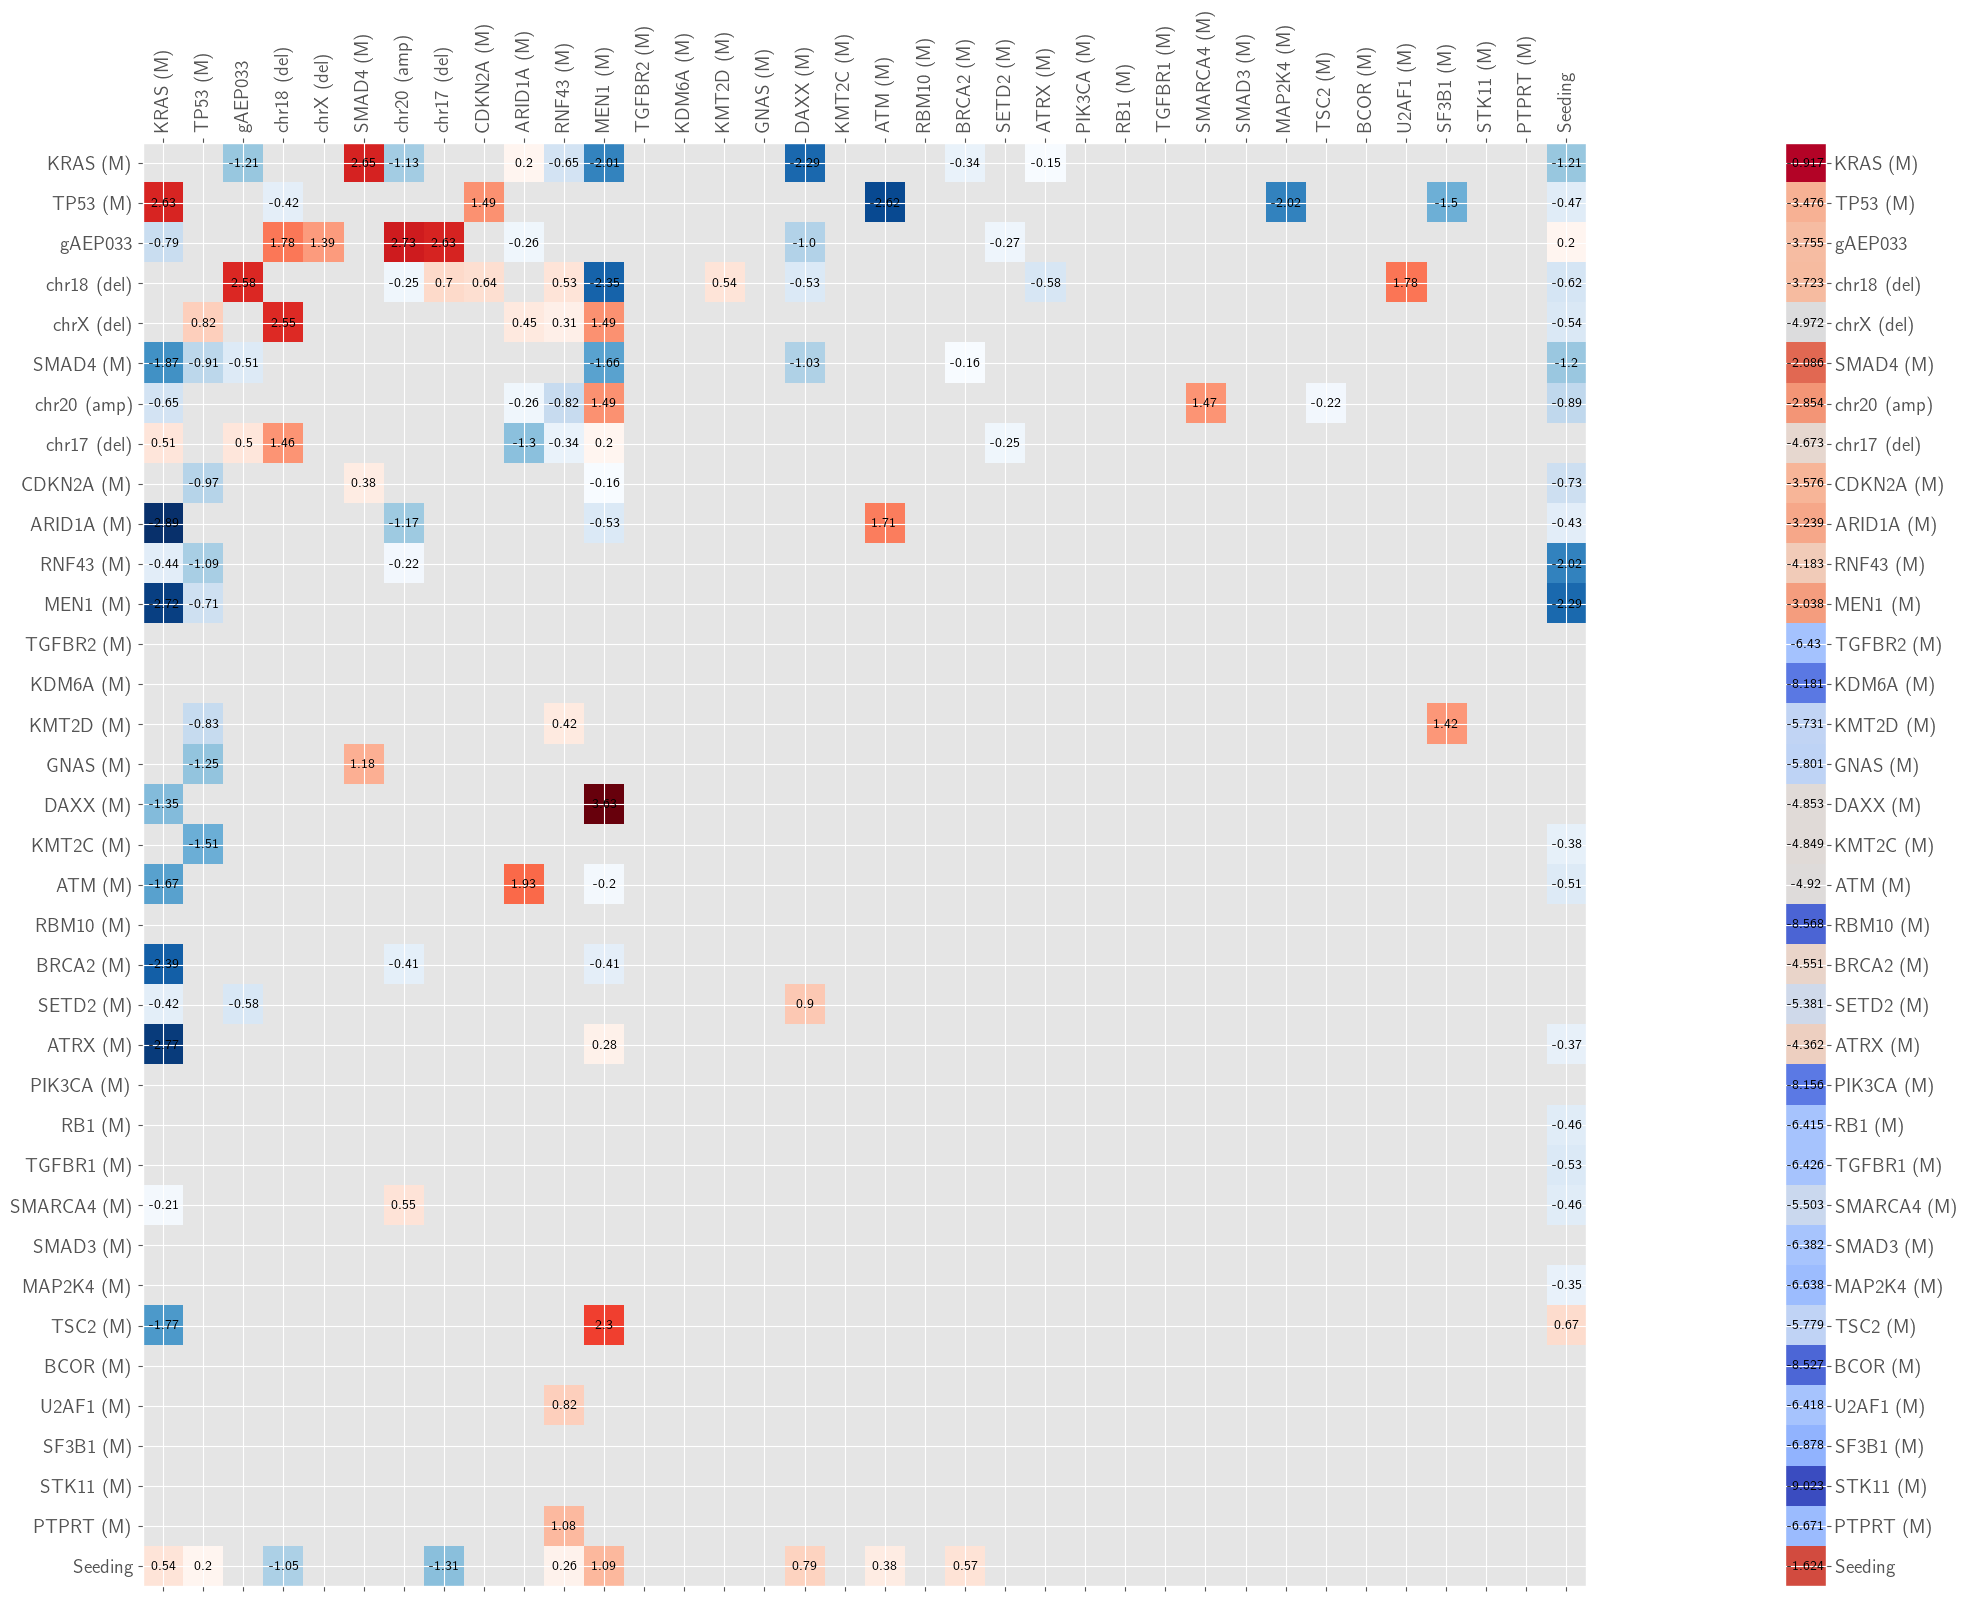

In [3]:
utils.plot_theta(params.iloc[:,:-1], .15)

In [4]:
probs_prim, probs_met = simul.p_full_orders(th_learned, n_sim, lam1, lam2, rng)
cum_probs_prim = np.cumsum(probs_prim, axis=0)
cum_probs_met = np.cumsum(probs_met, axis=0)

In [5]:
print(probs_prim)

[[0.43350201 0.03698309 0.04775135 ... 0.08235294 0.09663503 0.2534    ]
 [0.32574505 0.2235835  0.07758068 ... 0.08235294 0.07506471 0.24926   ]
 [0.14468302 0.33297635 0.09806735 ... 0.15294118 0.09836066 0.25694   ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [6]:
with PdfPages('paad_orders.pdf') as pdf:
    for i in range(n):
        fig,ax = plt.subplots(ncols=1, nrows=2, figsize=(11.69,8.27))
        
        ax[0].set_title(events[i]+": Order of accumulation")
        ax[0].bar(np.arange(1,21), probs_prim[:20,i], alpha=0.4, label="PT", color="blue")
        ax[0].bar(np.arange(1,21), probs_met[:20,i], color="red", alpha=0.4, label="MT")
        ax[0].set_xticks(np.arange(0,21))
        ax[0].legend()

        ax[1].set_title(events[i]+": Cumulative probability")
        ax[1].plot(np.arange(1,21), cum_probs_prim[:20,i],alpha=0.4, label="PT", linewidth="4", color="blue")
        ax[1].plot(np.arange(1,21), cum_probs_met[:20,i], color="red", alpha=0.4, label="MT", linewidth="4")
        ax[1].set_xticks(np.arange(0,21))
        ax[1].legend()

        pdf.savefig()
        plt.close()

In [7]:
mut_ps, mut_total = simul.p_mut_pre_seed(th_learned, n_sim, lam1, lam2, rng)
#mut_ps, mut_total_prim, mut_total_met = simul.p_mut_pre_seed_2(th_learned, n_sim, lam1, lam2, rng)

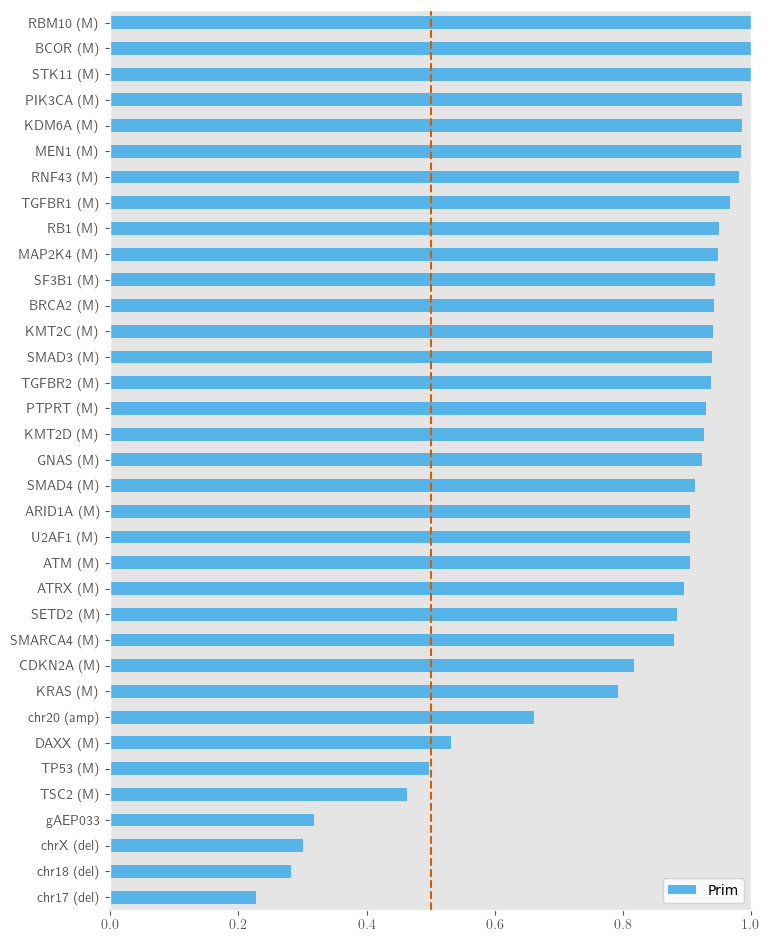

In [8]:
#psp = pd.DataFrame(np.column_stack((mut_ps/mut_total_prim, mut_ps/mut_total_met)), 
#                  index=events[:-1], columns=["Prim", "Met"])
psp = pd.DataFrame(mut_ps/mut_total, 
                   index=events[:-1], columns=["Prim"])
psp.sort_values(by=["Prim"], inplace=True)
fig, ax = plt.subplots(figsize=(8.27, 11.69))
plt.style.use("default")
ax.set_xlim(0,1)
ax.axvline(0.5, color = "#D55E00", linestyle="dashed")
psp["Prim"].plot(kind="barh", color="#56B4E9", ax=ax)
#psp["Met"].plot(kind="barh", ax=ax, color="red", alpha=0.4)
ax.legend()




In [9]:
res, iwas1, iwas2 = simul.simulate_dat(th_learned, 100000, lam1, lam2, rng)
res[:, -1].sum()/100000

0.7165